# Identifying Biological Structure From Data

In this notebook we reproduce the findings of section III from "Linear methods outperform foundation models due to manifold simplicity". First, we study in human spermatogenesis dataset the cosine similarity of the germ line cell family evolution. Then, we compare the cosine similarity across different species.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from tqdm import tqdm
try:
    import sctop as top
except:
    !pip install sctop
    import sctop as top
import scanpy as sc
from transcriptformer.datasets import bgee_testis_evolution
import anndata as ad
import mygene
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
from pybiomart import Server

We first load and prepare data for processing

In [2]:
human = bgee_testis_evolution(organism="human")
types_interest = ['late spermatid',
 'male germ line stem cell',
 'spermatocyte',
 'spermatogonium',
 'early spermatid']
human = human[human.obs['cell_type'].isin(types_interest)]
df = pd.DataFrame(human.X.toarray(), index = human.obs.index, columns = human.var.index).T

Now we process data using scTOP built-in function (see Methods section for description of how it works).

In [3]:
cell_type_column = 'cell_type'

atlas_metadata = human.obs

X_data = []
y_data = []
for cell_type in tqdm(types_interest, desc="Building raw train (all genes)"):
    cell_IDs = atlas_metadata[atlas_metadata[cell_type_column] == cell_type].index
    IDs = np.intersect1d(cell_IDs, df.columns)   # use ALL genes
    cell_data = df[IDs]
    processed = top.process(cell_data, average=True)
    X_data.append(processed.T.values)
    y_data.extend([cell_type] * processed.shape[1])

X_data = np.vstack(X_data)
y_data = np.array(y_data)

Building raw train (all genes): 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Definition of helper functions for computing cosine similarity and plotting.

In [9]:
import warnings

warnings.filterwarnings('ignore')


def compute_avg_similarity(X, labels, label_order):
    """
    Computes the average representation for each cell type and then
    the pairwise cosine similarity between those average representations.

    Args:
        X (np.array): The data matrix (cells x features).
        labels (np.array): The cell type labels for each row in X.
        label_order (list): The specific order for the cell types in the output matrix.

    Returns:
        pd.DataFrame: A (n_types x n_types) DataFrame of cosine similarities.
    """
    avg_repr = []
    for cell_type in label_order:
        mask = (labels == cell_type)
        if np.sum(mask) == 0:
            print(f"Warning: No cells found for {cell_type}")
            avg_repr.append(np.zeros(X.shape[1]))
        else:
            avg_repr.append(X[mask])

    avg_repr_matrix = np.vstack(avg_repr)

    sim_matrix = cosine_similarity(avg_repr_matrix)

    sim_df = pd.DataFrame(sim_matrix, index=label_order, columns=label_order)
    return sim_df

def plot_similarity_matrix(sim_df, title, save_path=None):
    """
    Plots a publication-quality cosine similarity matrix using LaTeX-style fonts
    and the original 'coolwarm' color scheme.
    """

    mpl.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "text.usetex": True,
        "axes.labelsize": 16,
        "axes.titlesize": 18,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "figure.dpi": 300,
        "axes.linewidth": 0.8
    })

    sns.set(style="white", font_scale=1.2)

    plt.figure(figsize=(8, 7))

    ax = sns.heatmap(
        sim_df,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        vmin=sim_df.min().min(),
        vmax=1,
        square=True,
        linewidths=0.5,
        cbar_kws={
            "shrink": 0.8,
            "label": r"\textbf{Cosine similarity}"
        }
    )

    ax.set_title(rf"\textbf{{{title}}}", pad=20)

    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Clean layout and aesthetics
    sns.despine(left=False, bottom=False)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", transparent=True)
    plt.show()


=== Computing Similarity: After top.process (All Genes) ===


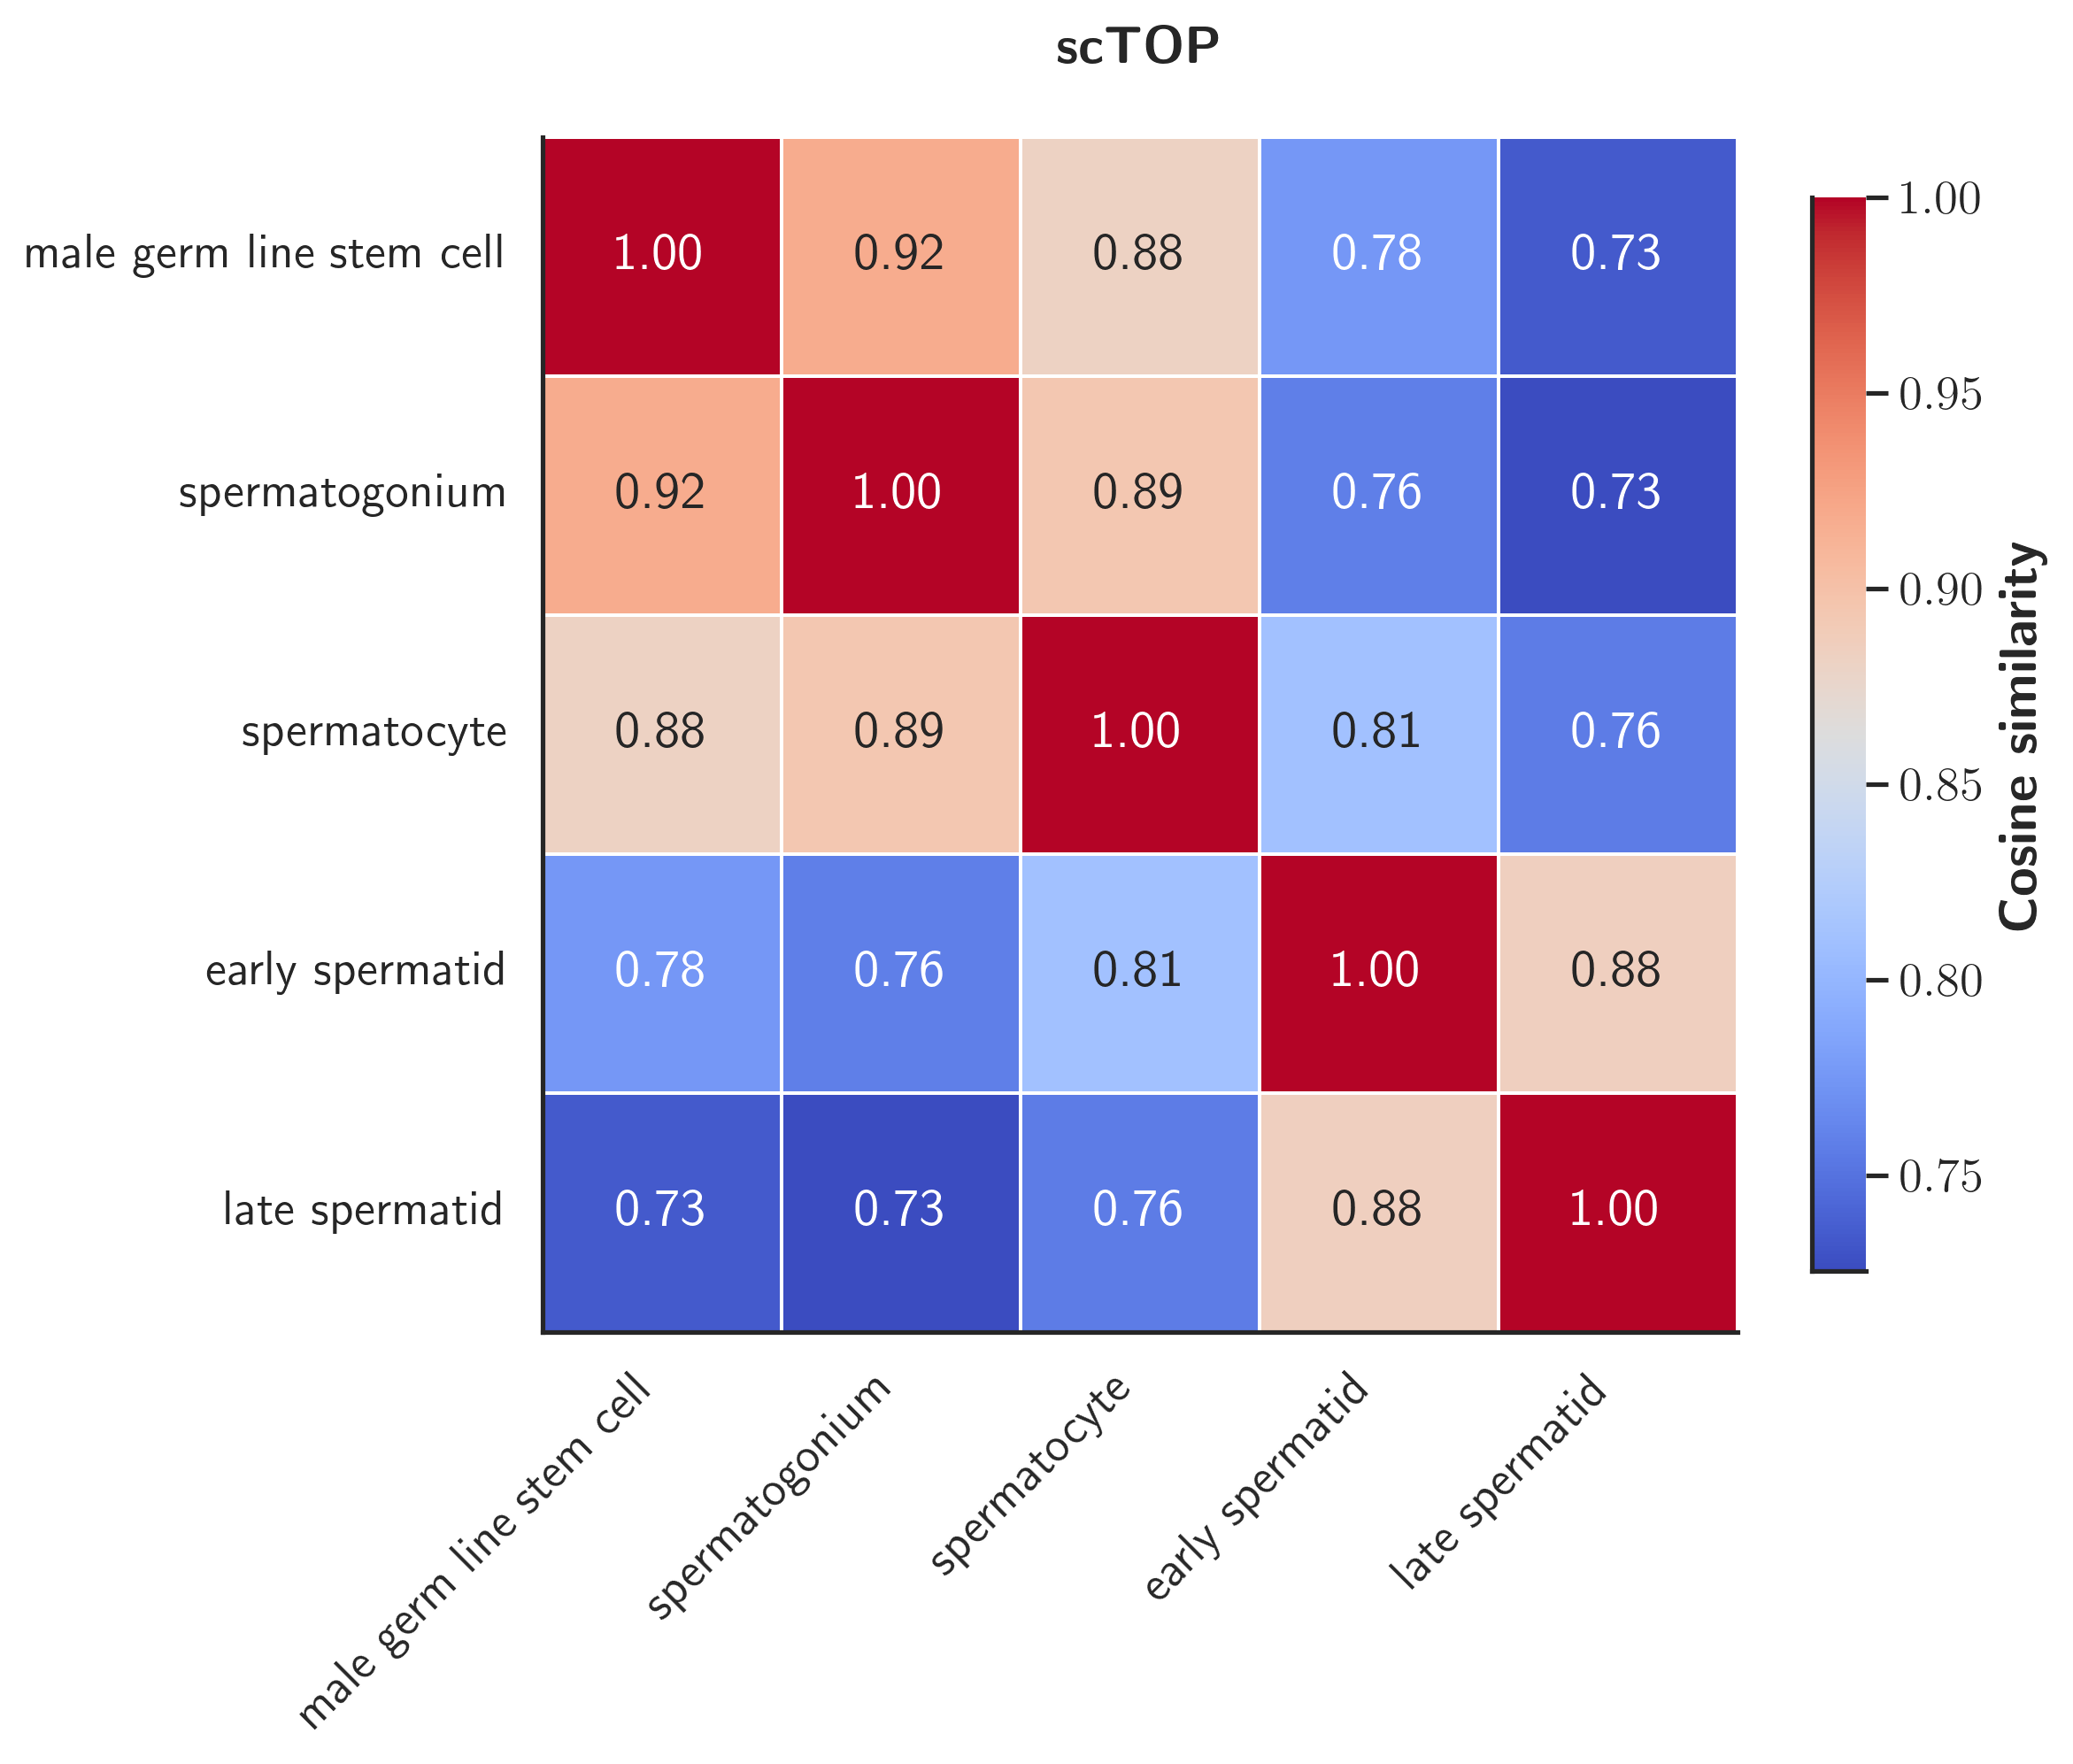

In [10]:
print("\n=== Computing Similarity: After top.process (All Genes) ===")
sim_df_all = compute_avg_similarity(X_data, y_data, ['male germ line stem cell', 'spermatogonium',
 'spermatocyte',
 'early spermatid', 'late spermatid'])
plot_similarity_matrix(sim_df_all, "scTOP", save_path='scTOP_cos_sim.svg')

## Similarity across species

Now, we move to the analysis across different species. For this, we need to use orthologs to map all genes to a common space.

Loading datasets...

Identifying common cell types across all species...
Common cell types found: ['early spermatid', 'late spermatid', 'somatic cell', 'spermatocyte', 'spermatogonium']
  human: 12327 cells, 34168 genes
  chimpanzee: 10460 cells, 15773 genes
  gorilla: 6297 cells, 19457 genes
  macaque: 6554 cells, 14722 genes
  marmoset: 5774 cells, 12237 genes
  mouse: 4750 cells, 24027 genes
  opossum: 8960 cells, 15793 genes
  platypus: 6749 cells, 18096 genes

Mapping all species to human gene space...


Fetching orthologs:  38%|███▊      | 3/8 [00:00<00:00,  6.75it/s]

  chimpanzee: 23182 ortholog mappings
  gorilla: 22592 ortholog mappings


Fetching orthologs:  50%|█████     | 4/8 [00:00<00:00,  7.53it/s]

  macaque: 20712 ortholog mappings
  marmoset: 19859 ortholog mappings


Fetching orthologs:  88%|████████▊ | 7/8 [00:01<00:00,  6.03it/s]

  mouse: 18247 ortholog mappings
  opossum: 15707 ortholog mappings


Fetching orthologs: 100%|██████████| 8/8 [00:01<00:00,  6.68it/s]


  platypus: 14924 ortholog mappings

Mapping genes to common space...
  human: 34168 genes (basis)
  chimpanzee: 14574 genes mapped to human
  gorilla: 16398 genes mapped to human
  macaque: 13551 genes mapped to human
  marmoset: 11497 genes mapped to human
  mouse: 15115 genes mapped to human
  opossum: 11809 genes mapped to human
  platypus: 13908 genes mapped to human

Finding common genes across all species...
Common genes across all species: 6077
  human: (12327, 6077)
  chimpanzee: (10460, 6077)
  gorilla: (6297, 6077)
  macaque: (6554, 6077)
  marmoset: (5774, 6077)
  mouse: (4750, 6077)
  opossum: (8960, 6077)
  platypus: (6749, 6077)

Processing embeddings for each species...


Processing species:   0%|          | 0/8 [00:00<?, ?it/s]

  Processing human with 6077 genes and 12327 cells...


Processing species:  12%|█▎        | 1/8 [00:08<01:01,  8.77s/it]

  human embedding shape: (6077,)
  Processing chimpanzee with 6077 genes and 10460 cells...


Processing species:  25%|██▌       | 2/8 [00:13<00:39,  6.66s/it]

  chimpanzee embedding shape: (6077,)
  Processing gorilla with 6077 genes and 6297 cells...


Processing species:  38%|███▊      | 3/8 [00:17<00:25,  5.06s/it]

  gorilla embedding shape: (6077,)
  Processing macaque with 6077 genes and 6554 cells...


Processing species:  50%|█████     | 4/8 [00:20<00:17,  4.33s/it]

  macaque embedding shape: (6077,)
  Processing marmoset with 6077 genes and 5774 cells...


Processing species:  62%|██████▎   | 5/8 [00:23<00:11,  3.78s/it]

  marmoset embedding shape: (6077,)
  Processing mouse with 6077 genes and 4750 cells...


Processing species:  75%|███████▌  | 6/8 [00:25<00:06,  3.27s/it]

  mouse embedding shape: (6077,)
  Processing opossum with 6077 genes and 8960 cells...


Processing species:  88%|████████▊ | 7/8 [00:29<00:03,  3.58s/it]

  opossum embedding shape: (6077,)
  Processing platypus with 6077 genes and 6749 cells...


Processing species: 100%|██████████| 8/8 [00:33<00:00,  4.13s/it]

  platypus embedding shape: (6077,)

Creating species embedding matrix...

Computing pairwise cosine similarity...


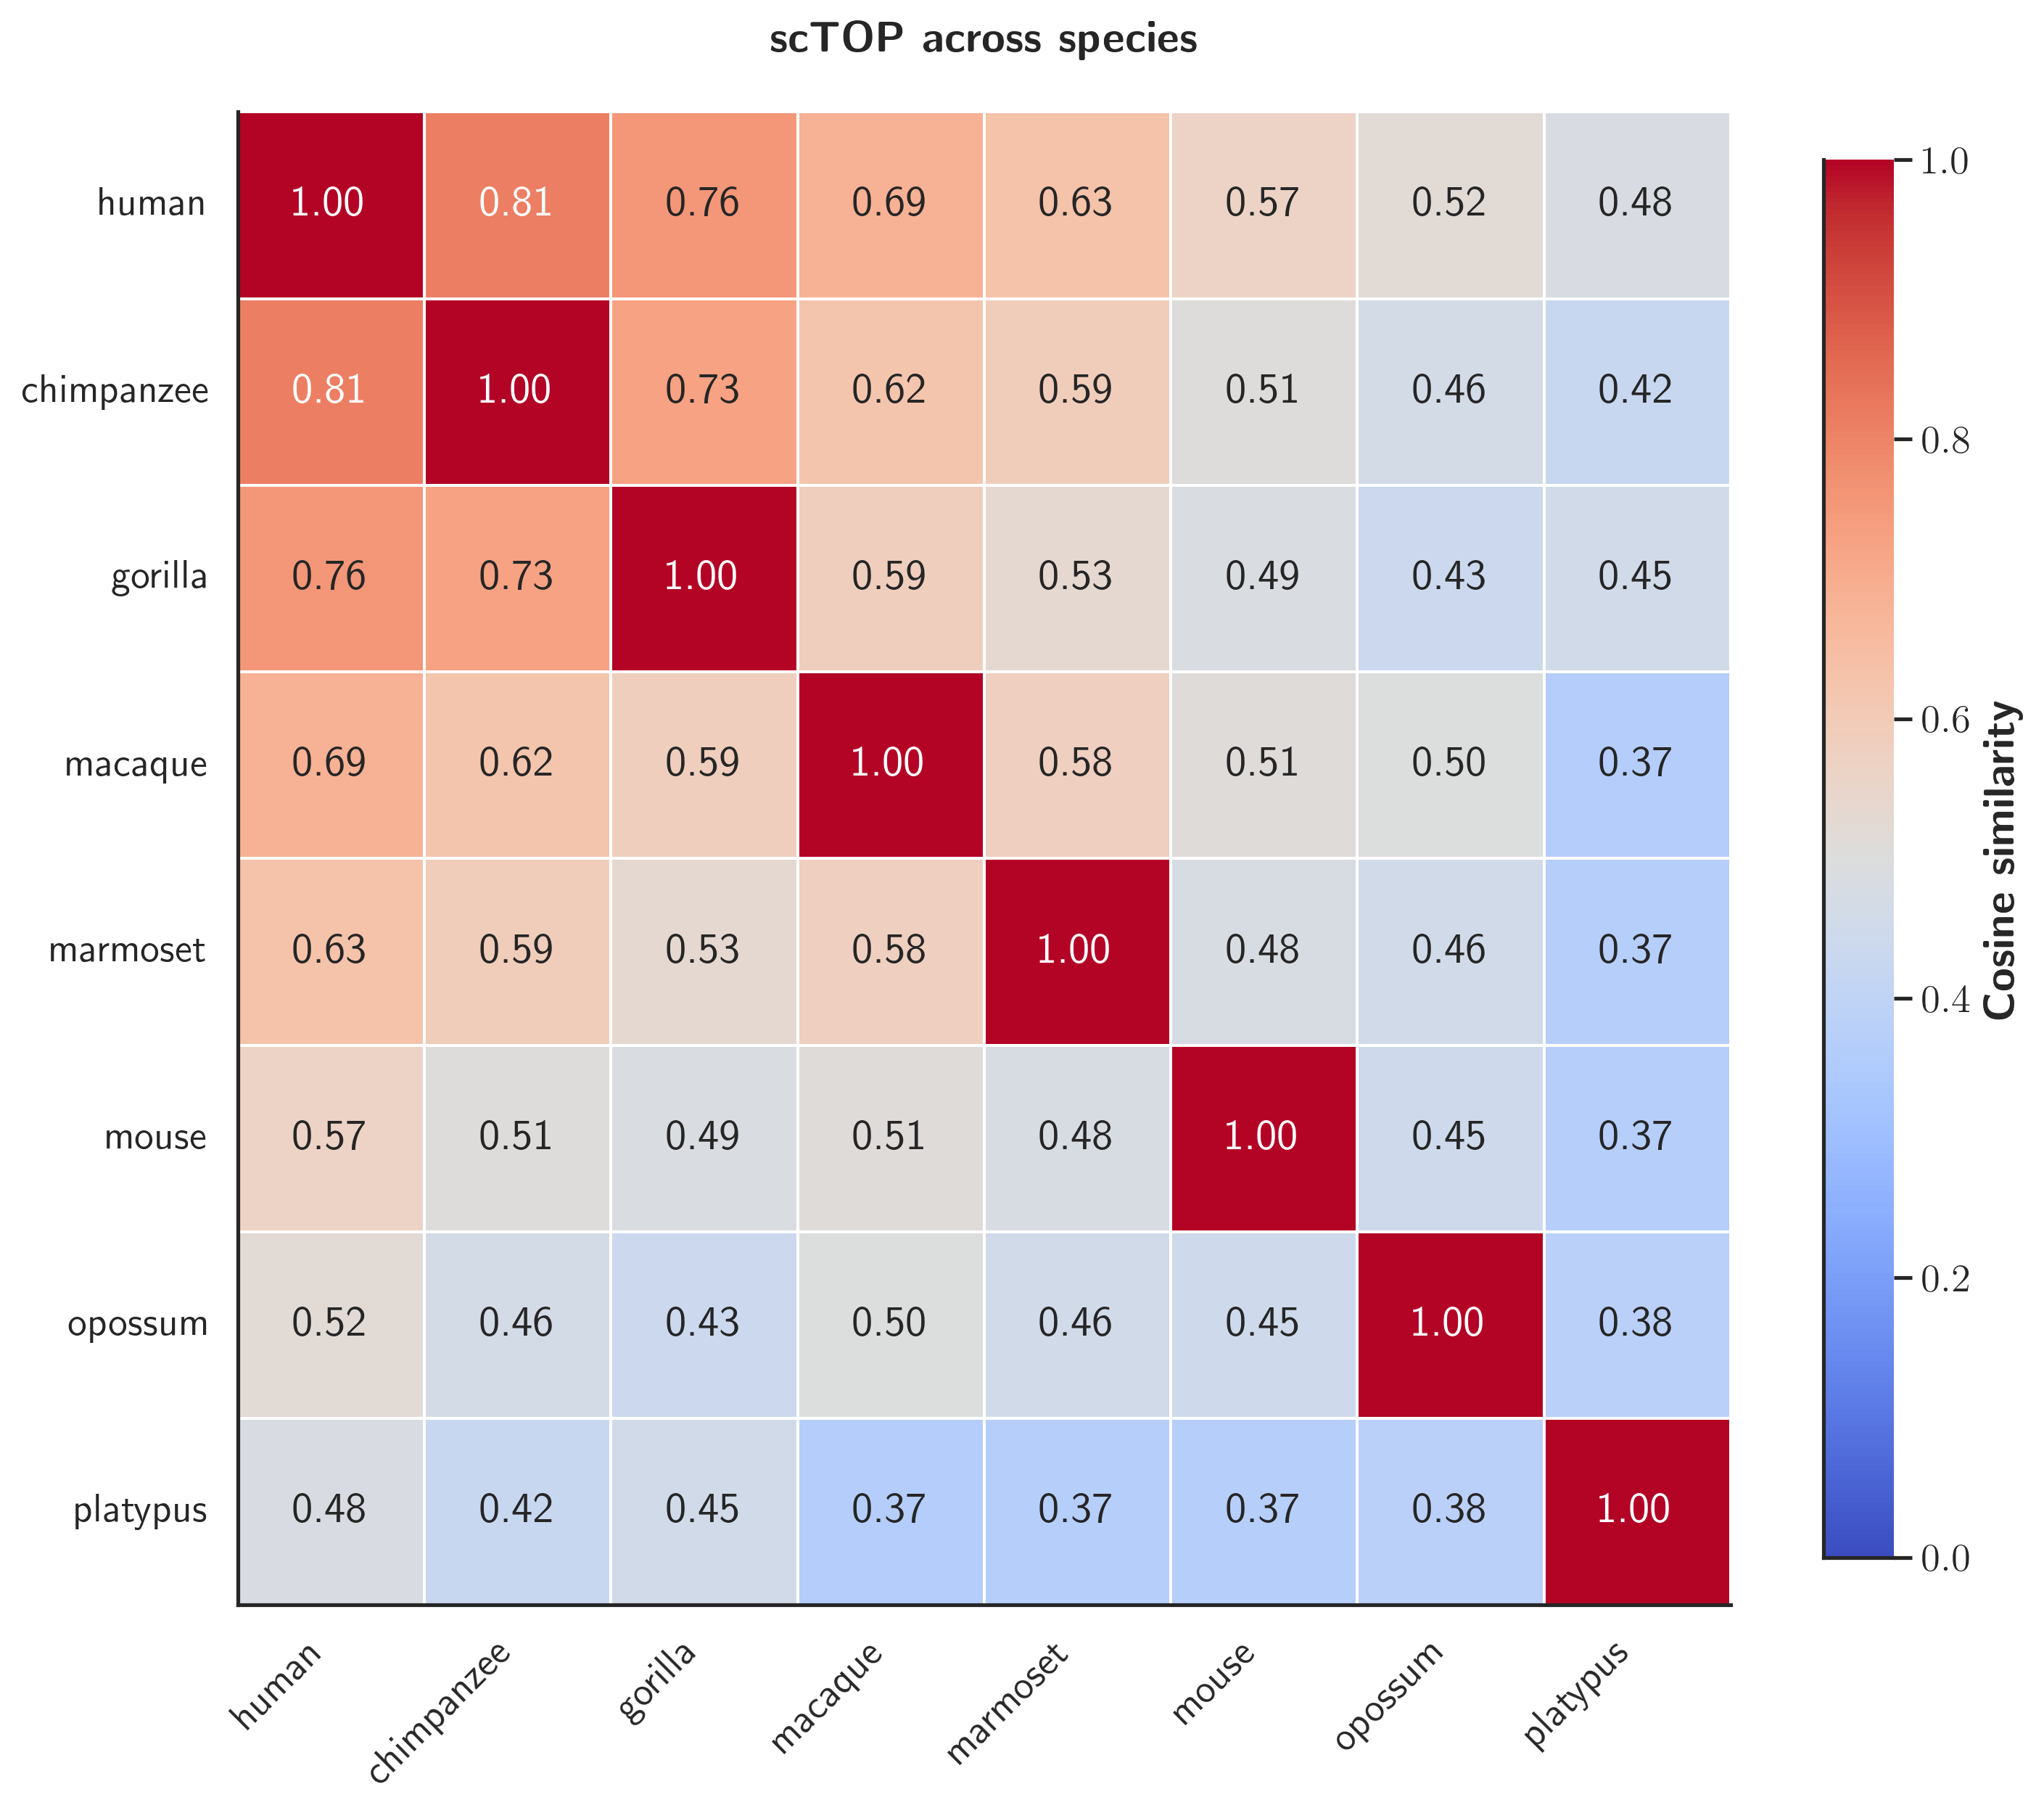

In [11]:
species_names = ["human", "chimpanzee", "gorilla", "macaque", "marmoset", "mouse", "opossum", "platypus"]

ENSEMBL_CONFIG = {
    'human':      {'dataset': 'hsapiens_gene_ensembl',  'prefix': 'hsapiens'},
    'chimpanzee': {'dataset': 'ptroglodytes_gene_ensembl','prefix': 'ptroglodytes'},
    'gorilla':    {'dataset': 'ggorilla_gene_ensembl',   'prefix': 'ggorilla'},
    'macaque':    {'dataset': 'mmulatta_gene_ensembl',   'prefix': 'mmulatta'},
    'marmoset':   {'dataset': 'cjacchus_gene_ensembl',   'prefix': 'cjacchus'},
    'mouse':      {'dataset': 'mmusculus_gene_ensembl',  'prefix': 'mmusculus'},
    'opossum':    {'dataset': 'mdomestica_gene_ensembl', 'prefix': 'mdomestica'},
    'platypus':   {'dataset': 'oanatinus_gene_ensembl',  'prefix': 'oanatinus'}
}

from pybiomart import Server
server = Server('http://www.ensembl.org')
ensembl_mart = server.marts['ENSEMBL_MART_ENSEMBL']

def get_ortholog_mapping(source_basis, target_species):
    """Fetches 1:1 orthologs: Target IDs -> Basis IDs."""
    if source_basis == target_species:
        return None
    
    source_prefix = ENSEMBL_CONFIG[source_basis]['prefix']
    target_dataset_name = ENSEMBL_CONFIG[target_species]['dataset']
    homolog_attr = f"{source_prefix}_homolog_ensembl_gene"
    
    try:
        dataset = ensembl_mart.datasets[target_dataset_name]
        df = dataset.query(attributes=['ensembl_gene_id', homolog_attr], use_attr_names=True)
        df = df.dropna().drop_duplicates()
        
        df = df.drop_duplicates(subset=['ensembl_gene_id'], keep='first')
        df = df.drop_duplicates(subset=[homolog_attr], keep='first')
        
        return df.set_index('ensembl_gene_id')[homolog_attr]
    except Exception as e:
        print(f"  Warning: Could not fetch mapping for {target_species}->{source_basis}: {e}")
        return pd.Series(dtype=str)

print("Loading datasets...")
adatas = {s: bgee_testis_evolution(organism=s) for s in species_names}

print("\nIdentifying common cell types across all species...")
common_cell_types = set(adatas[species_names[0]].obs['cell_type'].unique())
for species in species_names[1:]:
    common_cell_types = common_cell_types.intersection(
        set(adatas[species].obs['cell_type'].unique())
    )
common_cell_types = sorted(list(common_cell_types))
print(f"Common cell types found: {common_cell_types}")

for species in species_names:
    adatas[species] = adatas[species][adatas[species].obs['cell_type'].isin(common_cell_types)]
    print(f"  {species}: {adatas[species].shape[0]} cells, {adatas[species].shape[1]} genes")

basis_species = 'human'
print(f"\nMapping all species to {basis_species} gene space...")

ortholog_maps = {}
for species in tqdm(species_names, desc="Fetching orthologs"):
    if species == basis_species:
        ortholog_maps[species] = None
    else:
        ortholog_maps[species] = get_ortholog_mapping(basis_species, species)
        if ortholog_maps[species] is not None:
            print(f"  {species}: {len(ortholog_maps[species])} ortholog mappings")

print("\nMapping genes to common space...")
mapped_adatas = {}

for species in species_names:
    adata = adatas[species].copy()
    
    if species == basis_species:
        mapped_adatas[species] = adata
        print(f"  {species}: {adata.shape[1]} genes (basis)")
    else:
        if ortholog_maps[species] is not None:
            ortholog_map = ortholog_maps[species]
            
            valid_genes = adata.var.index.intersection(ortholog_map.index)

            adata = adata[:, valid_genes].copy()
            
            new_gene_names = [ortholog_map.loc[g] for g in adata.var.index]
            adata.var.index = new_gene_names
            
            unique_genes = ~adata.var.index.duplicated(keep='first')
            adata = adata[:, unique_genes].copy()
            
            mapped_adatas[species] = adata
            print(f"  {species}: {adata.shape[1]} genes mapped to {basis_species}")
        else:
            print(f"  Warning: No ortholog mapping for {species}")
            mapped_adatas[species] = adata

print("\nFinding common genes across all species...")
common_genes = set(mapped_adatas[species_names[0]].var.index)
for species in species_names[1:]:
    common_genes = common_genes.intersection(set(mapped_adatas[species].var.index))
common_genes = sorted(list(common_genes))
print(f"Common genes across all species: {len(common_genes)}")

for species in species_names:
    mapped_adatas[species] = mapped_adatas[species][:, common_genes].copy()
    print(f"  {species}: {mapped_adatas[species].shape}")

species_embeddings = {}
print("\nProcessing embeddings for each species...")

for species in tqdm(species_names, desc="Processing species"):
    species_data = mapped_adatas[species]
    
    df_species = pd.DataFrame(
        species_data.X.toarray() if hasattr(species_data.X, 'toarray') else species_data.X,
        index=species_data.obs.index,
        columns=species_data.var.index
    ).T
    
    print(f"  Processing {species} with {df_species.shape[0]} genes and {df_species.shape[1]} cells...")
    
    processed = top.process(df_species, average=False)
    
    species_embedding = processed.mean(axis=1).values
    species_embeddings[species] = species_embedding
    print(f"  {species} embedding shape: {species_embedding.shape}")

print("\nCreating species embedding matrix...")
embedding_matrix = np.vstack([species_embeddings[s] for s in species_names])

print("\nComputing pairwise cosine similarity...")
similarity_matrix = cosine_similarity(embedding_matrix)
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=species_names,
    columns=species_names
)

def plot_similarity_matrix(sim_df, title, save_path=None):
    """
    Plots a publication-quality cosine similarity matrix using LaTeX-style fonts
    and the original 'coolwarm' color scheme.
    """
    mpl.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "text.usetex": True,
        "axes.labelsize": 16,
        "axes.titlesize": 18,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "figure.dpi": 300,
        "axes.linewidth": 0.8
    })
    
    sns.set(style="white", font_scale=1.2)
    
    plt.figure(figsize=(10, 9))
    ax = sns.heatmap(
        sim_df,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        vmin=0.0, 
        vmax=1.0,
        square=True,
        linewidths=0.5,
        cbar_kws={
            "shrink": 0.8,
            "label": r"\textbf{Cosine similarity}"
        }
    )
    
    ax.set_title(rf"\textbf{{{title}}}", pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    sns.despine(left=False, bottom=False)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", transparent=True)
    plt.show()

plot_similarity_matrix(
    similarity_df,
    "scTOP across species",
    save_path = 'sctop_species_cos_sim.svg'
)

In [12]:
from scipy.stats import spearmanr

evolutionary_distances = {
    ('human', 'chimpanzee'): 6,
    ('human', 'gorilla'): 10,
    ('human', 'macaque'): 25,
    ('human', 'marmoset'): 35,
    ('human', 'mouse'): 90,
    ('human', 'opossum'): 160,
    ('human', 'platypus'): 177,
}

def get_distance_to_human(species):
    if species == "human":
        return 0
    if ("human", species) in evolutionary_distances:
        return evolutionary_distances[("human", species)]
    if (species, "human") in evolutionary_distances:
        return evolutionary_distances[(species, "human")]
    return None

def sctop_celltype_embedding(adata, cell_type, gene_list):
    """
    Compute a pseudo-bulk scTOP embedding for a given cell type in a given AnnData.
    - Subset to cell type
    - Use provided gene_list (already common genes in your pipeline)
    - top.process(..., average=False)
    - Mean across cells AFTER processing -> 1D vector
    """
    ad_ct = adata[adata.obs["cell_type"] == cell_type, gene_list].copy()
    if ad_ct.n_obs == 0:
        return None

    X = ad_ct.X
    if hasattr(X, "toarray"):
        X = X.toarray()

    df = pd.DataFrame(X, index=ad_ct.obs_names, columns=ad_ct.var_names).T

    processed = top.process(df, average=False)  
    v = processed.mean(axis=1).values            
    return v


human_adata = mapped_adatas["human"]  
gene_list = list(human_adata.var_names) 

rows = []
for sp in tqdm(species_names):
    dist = get_distance_to_human(sp)
    if dist is None:
        continue
    if sp == "human":
        continue 

    ad_sp = mapped_adatas[sp]

    for ct in common_cell_types:
        v_h = sctop_celltype_embedding(human_adata, ct, gene_list)
        v_s = sctop_celltype_embedding(ad_sp, ct, gene_list)

        if (v_h is None) or (v_s is None):
            continue

        sim = float(cosine_similarity(v_h.reshape(1, -1), v_s.reshape(1, -1))[0, 0])

        rows.append({
            "species": sp,
            "cell_type": ct,
            "distance_mya": dist,
            "cosine_similarity": sim
        })

df_points = pd.DataFrame(rows)

corr, pval = spearmanr(df_points["distance_mya"], df_points["cosine_similarity"])
print(f"Spearman r = {corr:.3f}, p = {pval:.4g}")

100%|██████████| 8/8 [01:10<00:00,  8.78s/it]

Spearman r = -0.876, p = 5.837e-12


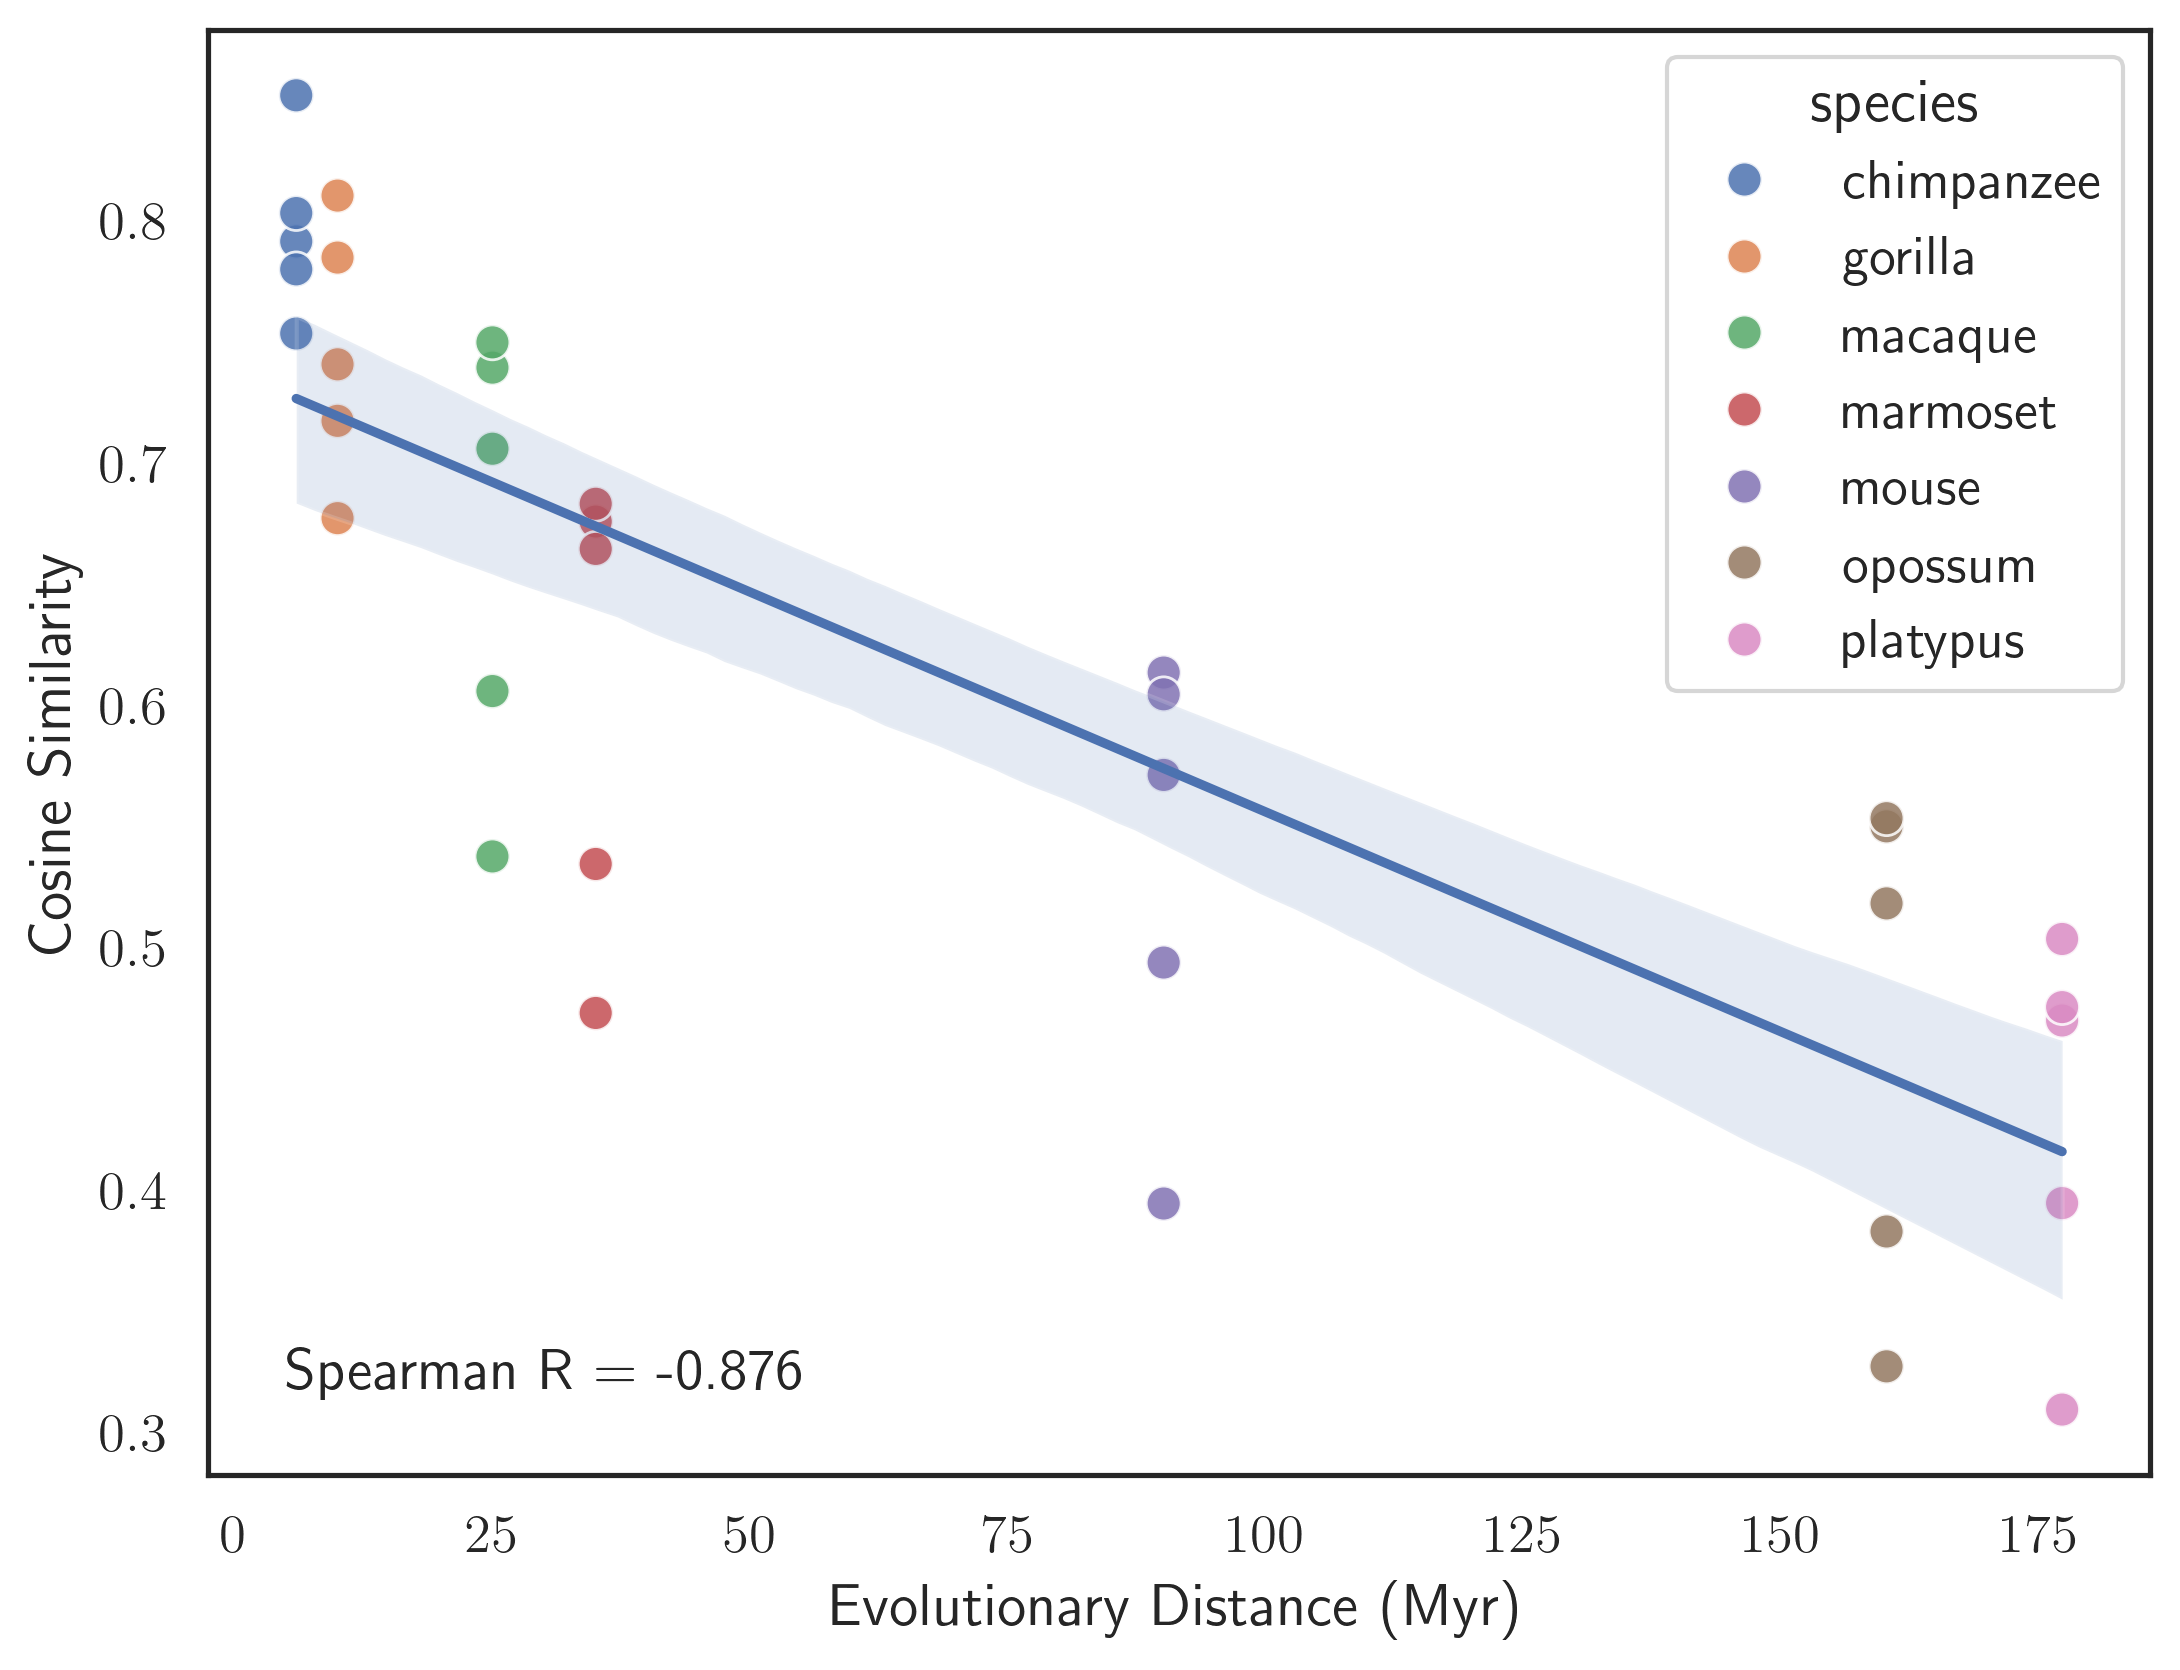

In [13]:
plt.figure(figsize=(7.5, 5.8))

ax = sns.scatterplot(
    data=df_points,
    x="distance_mya",
    y="cosine_similarity",
    hue="species",
    s=70,
    alpha=0.85
)

sns.regplot(
    data=df_points,
    x="distance_mya",
    y="cosine_similarity",
    scatter=False,
    ci=95,
    ax=ax
)

ax.set_xlabel("Evolutionary Distance (Myr)")
ax.set_ylabel("Cosine Similarity")

ax.text(
    0.04, 0.06,
    f"Spearman R = {corr:.3f}",
    transform=ax.transAxes,
    fontsize=14
)

plt.tight_layout()
plt.savefig("evolution_similarity_by_celltype.svg", bbox_inches="tight", transparent=True)
plt.show()